In [188]:
import matplotlib.pyplot as plt
import scipy
import numpy as np
from astropy.coordinates import SkyCoord
from astropy.io import fits
import lightkurve as lk
import glob
from tqdm import tqdm
import pickle

import sys
plt.rcParams.update({'font.size': 22})

sys.path.append('../../WD_models/')
from sed_fitter import FitSED

plt.style.use('vedant')

c = 2.998e10
k = 1.38e-16
h = 6.626e-27

from scipy.interpolate import RegularGridInterpolator as rgi
from scipy.interpolate import LinearNDInterpolator as lndi

In [197]:
wd_files = glob.glob('blouin/lowlogg_H4/*')

In [301]:
wd_fls = [];
wd_teffs = [];
wd_loggs = [];
wd_wls = [];
wd_cahs = [];

for file in tqdm(wd_files):
    
    f = open(file)
    lines = f.readlines()
    f.close()

    wl = [];
    for line in lines[16:2169]:
        wl_seg = [float(jj) for jj in line.split()]
        wl.extend(wl_seg)

    for line in lines[2169:2204]:

        wl_seg_str = [line[0:8], line[8:16], line[16:24], line[24:32], line[32:40], line[40:48], line[48:56],
                      line[56:64], line[64:72], line[72:80]]
        wl_seg = [float(wlseg) for wlseg in wl_seg_str]
        wl.extend(wl_seg)

    line = lines[2204]
    wl_seg_str = [line[0:8], line[8:16], line[16:24], line[24:32], line[32:40], line[40:48]]
    wl_seg = [float(wlseg) for wlseg in wl_seg_str]
    wl.extend(wl_seg)

    wl = np.asarray(wl[18:])

    logg = np.log10(float(lines[2205].split()[6]))
    cah = np.log10(float(lines[2205].split()[12]))

    for line in (lines[2205:]):
        idx = lines.index(line) + 29
        if  'Effective' in line.split()[0]:
            
            print('spec')
            
            teff = float(line.split()[3])
            
            fl = [];
            for subline in lines[idx:(idx+3645)]:
                fl_seg = [float(jj) for jj in subline.split()]
                fl.extend(fl_seg)

            fl = np.asarray(fl)

            wd_fls.append(fl)
            wd_teffs.append(teff)
            wd_loggs.append(logg)
            wd_cahs.append(cah)
            wd_wls.append(wl)
    break

  0%|          | 0/50 [00:00<?, ?it/s]

spec
spec
spec
spec
spec
spec
spec


  0%|          | 0/50 [00:05<?, ?it/s]


In [304]:
wd_fls[5]

array([1.3541e-81, 3.3912e-81, 2.1316e-80, ..., 4.0449e-07, 3.9677e-07,
       3.8920e-07])

(6500.0, 6600.0)

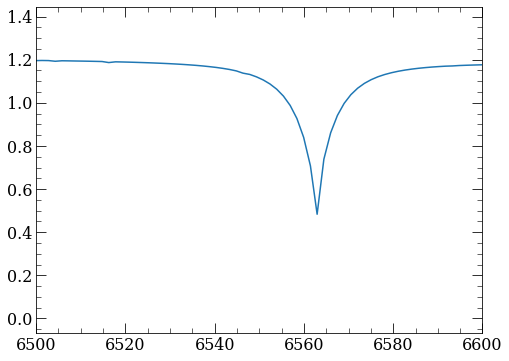

In [241]:
plt.plot(wl, fl / np.median(fl))
plt.xlim(6500, 6600)

In [256]:
wd_fls = np.asarray(wd_fls)
wd_wls = np.asarray(wd_wls)
wd_loggs = np.asarray(wd_loggs)
wd_teffs = np.asarray(wd_teffs)
wd_cahs = np.asarray(wd_cahs)

In [243]:
all_data = (wd_wls[0], wd_fls, wd_teffs, wd_loggs, wd_cahs)

In [244]:
pickle.dump(all_data, open('blouin/spec.pkl', 'wb'))

In [310]:
wl, wd_fls, wd_teffs, wd_loggs, wd_cahs = pickle.load(open('blouin/spec.pkl', 'rb'))

In [311]:
wd_cahs = np.asarray(wd_cahs)

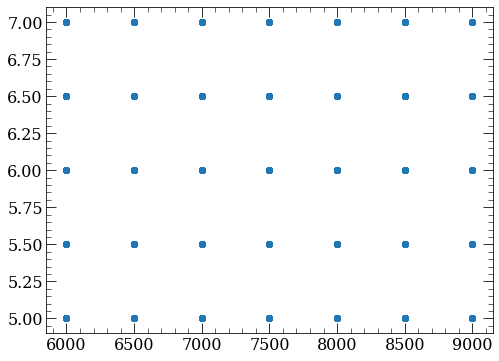

In [312]:
plt.scatter(wd_teffs, wd_loggs)

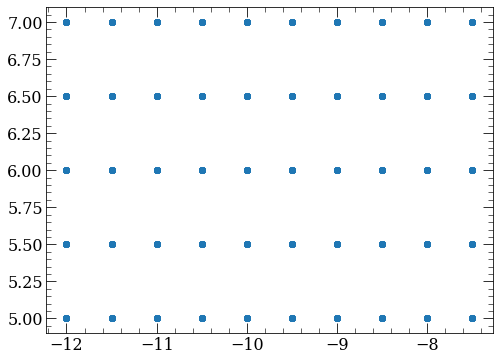

In [313]:
plt.scatter(wd_cahs, wd_loggs)

In [314]:
teffs = np.sort(wd_teffs[(wd_loggs == 6)*(wd_cahs == -10)])
loggs = np.sort(wd_loggs[(wd_teffs == 6000)*(wd_cahs == -10)])
cahs = np.sort(wd_cahs[(wd_teffs == 6000)*(wd_loggs == 6)])

In [317]:
cahs

array([-12.        , -11.50003813, -11.        , -10.50003813,
       -10.        ,  -9.50003813,  -9.        ,  -8.50003813,
        -8.        ,  -7.50003813])

In [320]:
A,B,C,D = np.meshgrid(teffs, loggs, cahs, np.log10(wl))
vals = np.zeros(A.shape)

In [322]:
(wd_cahs == wd_cahs[kk])

array([ True,  True,  True,  True,  True,  True,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True,  True,  True,  True,  True,  True,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [330]:
vals.shape[2]

10

In [335]:
len(cahs)

10

In [338]:
A[0, 0, 0]

array([6000., 6000., 6000., ..., 6000., 6000., 6000.])

In [344]:
for ii in tqdm(range(vals.shape[0])):
    for jj in range(vals.shape[1]):
        for kk in range(vals.shape[2]):
            
            search = (
                (wd_teffs == A[ii, jj, kk, 0])*
                (wd_loggs == B[ii, jj, kk, 0])*
                (wd_cahs == C[ii, jj, kk, 0])
            
            )
                        
            #print(np.sum(search))
            fl =  wd_fls[search][0]
            #print(fl)
            for aa in range(vals.shape[3]):
                vals[ii, jj, kk, aa] = np.log10(fl[aa])

100%|██████████| 5/5 [00:11<00:00,  2.40s/it]


In [345]:
interpwd = rgi(points = [loggs, teffs, cahs, np.log10(wl)], values = vals)

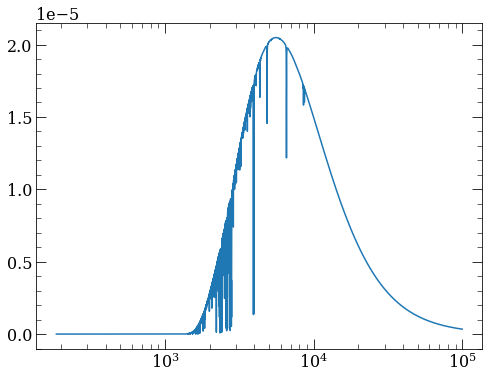

In [346]:
plt.plot(wl, 10**interpwd((6, 7900, -11, np.log10(wl))))
plt.xscale('log')

In [347]:
pickle.dump(interpwd, open('blouin/interpwd.pkl', 'wb'))

In [295]:
cahs

array([-12.        , -11.50003813, -11.        , -10.50003813,
       -10.        ,  -9.50003813,  -9.        ,  -8.50003813,
        -8.        ,  -7.50003813])